# Поиск остовного дерева минимального веса на динамических графах

In [1]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt

## Генерация исходного графа

In [294]:
n = 10
k = 0
while (k != n):
    m = np.random.randint(0, 5, size=(n, n))
    np.fill_diagonal(m, 0)
    for i in range(n):
        for j in range(i):
            m[i, j] = m[j, i]
    k = sum(m.sum(axis=0)>0)
#print(m)

In [313]:
m = np.array([[0, 5, 0, 0, 0, 0, 0, 0, 0, 0],
    [5, 0, 3, 0, 0, 0, 0, 0, 0, 0],
    [0, 3, 0, 2, 0, 0, 3, 5, 0, 0],
    [0, 0, 2, 0, 3, 0, 0, 0, 0, 0],
    [0, 0, 0, 3, 0, 4, 0, 0, 0, 0],
    [0, 0, 0, 0, 4, 0, 0, 0, 0, 2],
    [0, 0, 3, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 5, 0, 0, 0, 0, 0, 4, 0],
    [0, 0, 0, 0, 0, 0, 0, 4, 0, 2],
    [0, 0, 0, 0, 0, 2, 0, 0, 2, 0]])

Поиск оптимальных точек

In [314]:
g = m.copy()
g[g == 0] = 2000000000

In [160]:
%%time
d = g[4]
mark = np.full(n, False)
d[4] = 0
mark[4] = True
for _ in range(1, n):
    v = -1
    for i in range(n):
        if (not mark[i]):
            if (v == -1):
                v = i
            elif (d[v] > d[i]):
                v = i
    mark[v] = True
    for i in range(n):
        if d[i] > d[v] + g[v][i]:
            d[i] = d[v] + g[v][i]
#d

Wall time: 0 ns


In [161]:
%%time
d = g[4]
mark = np.full(n, False)
d[4] = 0
mark[4] = True
for _ in range(1, n):
    v = np.where(~mark == True)[0][d[~mark].argmin()]
    mark[v] = True
    for i in range(n):
        d[i] = min(d[i], d[v] + g[v][i]) 
#d

Wall time: 0 ns


In [315]:
%%time
res = np.empty((0, n), int)
for i in range(n):
    d = g[i]
    mark = np.full(n, False)
    d[i] = 0
    mark[i] = True
    for _ in range(1, n):
        v = np.where(~mark == True)[0][d[~mark].argmin()]
        mark[v] = True
        d = np.array([min(d[i], d[v] + g[v][i]) for i in range(n)])
    res = np.vstack((res, d))
res 

Wall time: 2 ms


array([[ 0,  5,  8, 10, 13, 17, 11, 13, 17, 19],
       [ 5,  0,  3,  5,  8, 12,  6,  8, 12, 14],
       [ 8,  3,  0,  2,  5,  9,  3,  5,  9, 11],
       [10,  5,  2,  0,  3,  7,  5,  7, 11,  9],
       [13,  8,  5,  3,  0,  4,  8, 10,  8,  6],
       [17, 12,  9,  7,  4,  0, 12,  8,  4,  2],
       [11,  6,  3,  5,  8, 12,  0,  8, 12, 14],
       [13,  8,  5,  7, 10,  8,  8,  0,  4,  6],
       [17, 12,  9, 11,  8,  4, 12,  4,  0,  2],
       [19, 14, 11,  9,  6,  2, 14,  6,  2,  0]])

In [316]:
marks = np.full(n, False)
points = []
tm = 5
while marks.sum() < n:
    ix = (res[:, ~marks][~marks] <= tm).sum(axis=0).argmax()
    x = np.where(~marks == True)[0][ix]
    points.append(x)
    marks[np.where((res[x] <= tm) == True)] = True
points

[2, 5, 0]

### Визуализация

In [372]:
def create_nodes(graph, n):
    graph.add_nodes_from([(i, {'station': f'st{i}'}) for i in range(n)])

In [373]:
def create_edges(graph, m):
    for i in range(n):
        for j in range(n):
            if m[i,j] > 0:
                graph.add_edge(i, j, weight=m[i,j])


In [652]:
def draw(graph, points, res_col="red"):
     plt.figure(2,figsize=(50,50))
     plt.title('Graph')
     pos = nx.kamada_kawai_layout(graph)
     nx.draw(graph,
          pos=pos,
          node_color='Lavender',
          node_size=500,
          #labels=nx.get_node_attributes(graph, 'station'),
          with_labels=True)
     nx.draw_networkx_nodes(graph, 
                         pos, 
                         nodelist=points, 
                         node_size=500,
                         alpha=0.5, 
                         node_color=res_col) 
     nx.draw_networkx_edge_labels(graph,
                              pos,
                              edge_labels=nx.get_edge_attributes(graph,'weight'))


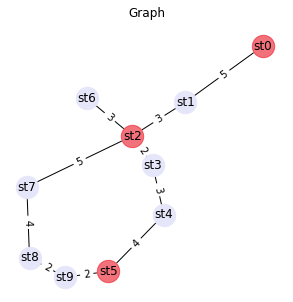

In [375]:
graph = nx.Graph()
create_nodes(graph, n)
create_edges(graph, m)
draw(graph, points)

In [493]:
import re
import pandas as pd
import json

In [602]:
transfers = pd.read_csv('transfers.txt', sep="[=,]+", engine='python', encoding="utf-8")

In [603]:
transfers.head()

,место,линия1,станция1,линия2,станция2,время
0,Китай-город,Таганско-Краснопресненская,Китай-город,Калужско-Рижская,Китай-город,1.0
1,Комсомольская,Сокольническая,Комсомольская,Кольцевая,Комсомольская,5.0
2,Курская1,Арбатско-Покровская,Курская,Кольцевая,Курская,3.0
3,Курская2,Кольцевая,Курская,Люблинско-Дмитровская,Чкаловская,4.0
4,Курская3,Арбатско-Покровская,Курская,Люблинско-Дмитровская,Чкаловская,2.0


In [628]:
station_nodes = []
for i, node_part in transfers.iterrows():
    flag = False
    for node in station_nodes:
        if node_part['станция1'] in node:
            flag = True
            node.add(node_part['станция2'])
        elif node_part['станция2'] in node:
            flag = True
            node.add(node_part['станция1'])
    if not flag:
        part_set = set()
        part_set.add(node_part['станция1'])
        part_set.add(node_part['станция2'])
        station_nodes.append(part_set)
station_nodes[:5]


[{'Китай-город'},
 {'Комсомольская'},
 {'Курская', 'Чкаловская'},
 {'Марксистская', 'Таганская'},
 {'Павелецкая'}]

In [512]:
with open('data.json', 'w') as outfile:
    json.dump(lines, outfile)

In [514]:
with open('data.json') as json_file:
    data = json.load(json_file)

In [669]:
lines = []
with open('lines.txt', encoding="utf-8") as read_file:
    for line in read_file:
        line = line.strip().replace(';', '')
        if re.search(r'\[Line(\d+)\]', line):
            lines.append({'number':re.search(r'\[Line(\d+)\]', line).group(1)})
        else:
            l_sp = line.split("=")
            if l_sp[0] == 'Name':
                lines[-1]['name'] = l_sp[1]
            if l_sp[0] == 'Stations':
                lines[-1]['stations'] = []
                l = re.sub('\(.+?\)', '', l_sp[1])
                lines[-1]['stations'].extend(l.split(','))
            if l_sp[0] == 'Driving':
                lines[-1]['time'] = []
                l = re.sub('\(.+?\)', '-1', l_sp[1])
                lines[-1]['time'].extend(list(map(lambda x: float(x),l.split(','))))
    

In [670]:
lines

[{'number': '1',
  'name': 'Сокольническая',
  'stations': ['Бульвар Рокоссовского',
   'Черкизовская',
   'Преображенская площадь',
   'Сокольники',
   'Красносельская',
   'Комсомольская',
   'Красные ворота',
   'Чистые пруды',
   'Лубянка',
   'Охотный ряд',
   'Библиотека имени Ленина',
   'Кропоткинская',
   'Парк культуры',
   'Фрунзенская',
   'Спортивная',
   'Воробьевы горы',
   'Университет',
   'Проспект Вернадского',
   'Юго-Западная',
   'Тропарёво',
   'Румянцево',
   'Саларьево',
   'Филатов Луг',
   'Прокшино',
   'Ольховая',
   'Коммунарка'],
  'time': [3.0,
   3.0,
   4.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   3.0,
   2.0,
   2.0,
   3.0,
   3.0,
   3.0,
   3.0,
   4.0,
   3.0,
   3.0,
   4.0,
   4.0,
   4.0,
   2.0]},
 {'number': '2',
  'name': 'Замоскворецкая',
  'stations': ['Речной вокзал',
   'Водный стадион',
   'Войковская',
   'Сокол',
   'Аэропорт',
   'Динамо',
   'Белорусская',
   'Маяковская',
   'Тверская',
   'Театральная',


In [671]:
stations_dict = {}
k = 0
for row in lines:
    for station in row['stations']:
        stations_node = set([station])
        for sn in station_nodes:
            if station in sn:
                stations_node = sn    
        if not station in stations_dict.keys():
            for st in stations_node:
                stations_dict[st] = k
            k += 1
    

In [672]:
n= len(stations_dict)
m = np.zeros((n, n))
for row in lines:
    for i in range(len(row['stations'])-1):
        #print(row, row['stations'][i], row['stations'][i+1])
        m[stations_dict[row['stations'][i]], stations_dict[row['stations'][i+1]]] = row['time'][i]
        m[stations_dict[row['stations'][i+1]], stations_dict[row['stations'][i]]] = row['time'][i]

In [673]:
def draw(graph, points, res_col="red"):
     plt.figure(2,figsize=(50,50))
     plt.title('Graph')
     pos = nx.kamada_kawai_layout(graph)
     nx.draw(graph,
          pos=pos,
          node_color='Lavender',
          node_size=500,
          #labels=nx.get_node_attributes(graph, 'station'),
          with_labels=True)
     nx.draw_networkx_nodes(graph, 
                         pos, 
                         nodelist=points, 
                         node_size=500,
                         alpha=0.5, 
                         node_color=res_col) 
     nx.draw_networkx_edge_labels(graph,
                              pos,
                              edge_labels=nx.get_edge_attributes(graph,'weight'))


C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


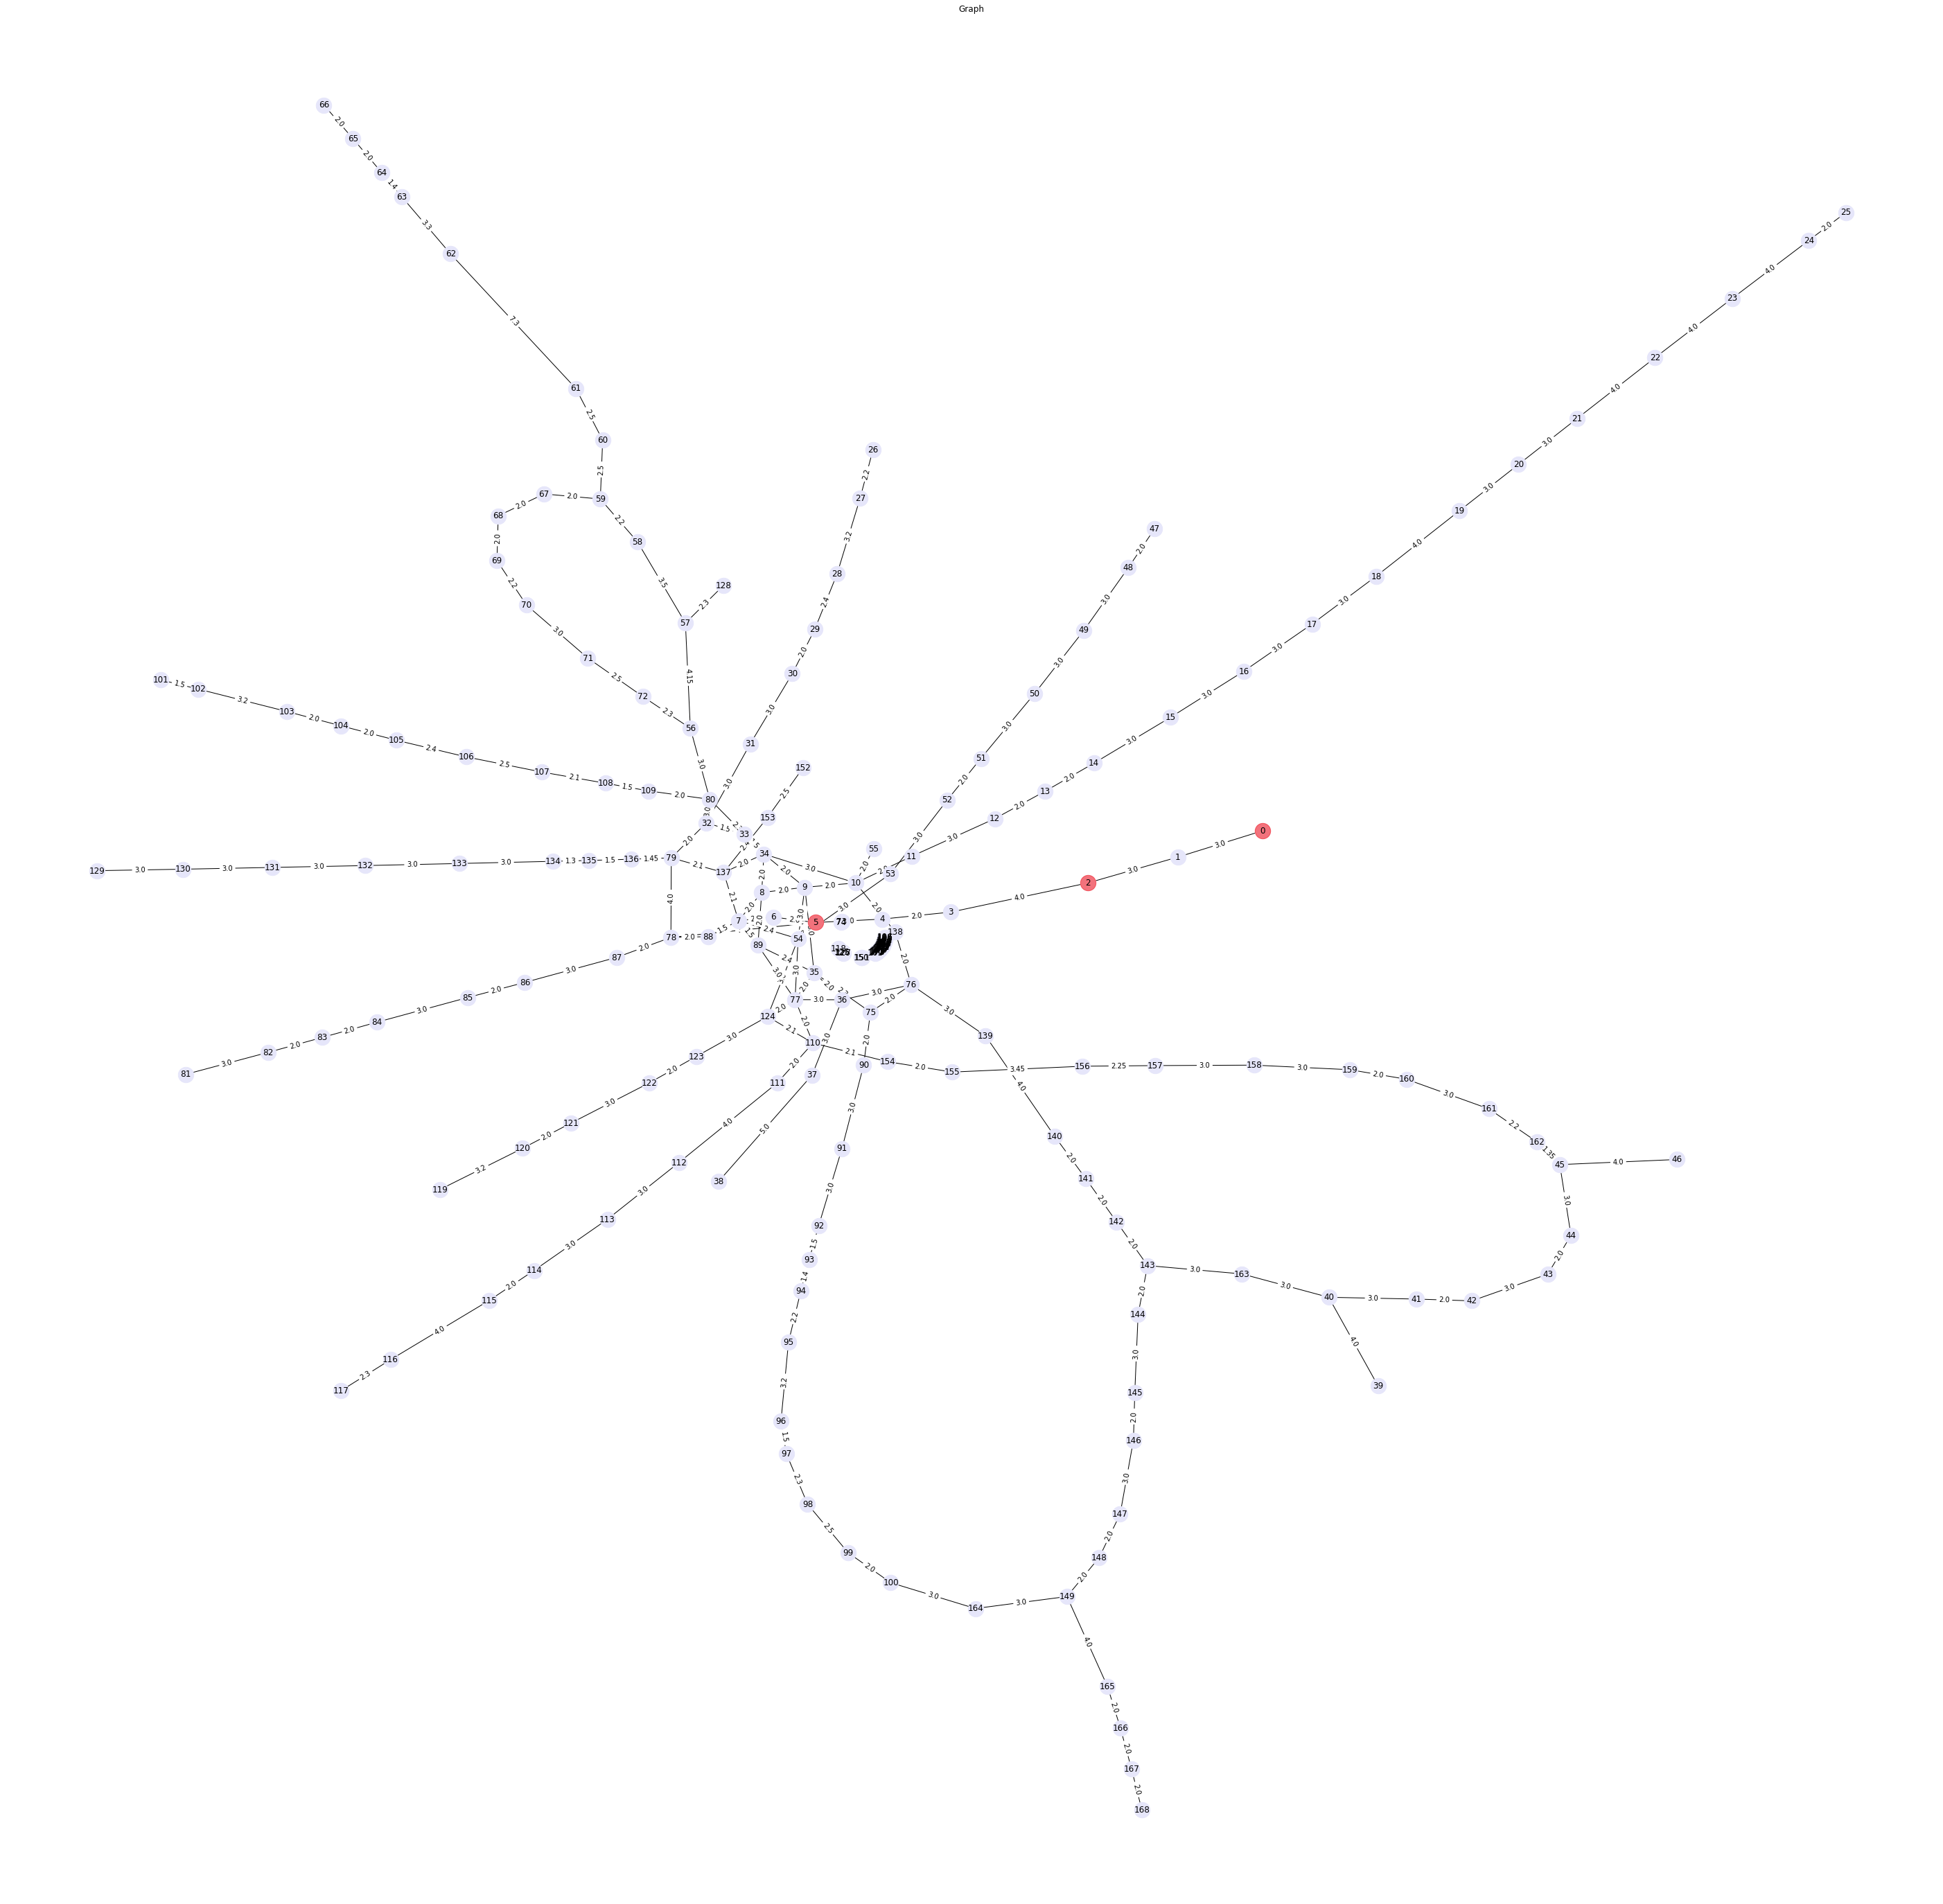

In [674]:
graph = nx.Graph()
create_nodes(graph, n)
create_edges(graph, m)
draw(graph, points)

In [661]:
from pyvis.network import Network
def create_nodes_pyvis(graph, n):
    graph.add_nodes([i for i in range(n)])
    
def create_edges_pyvis(graph, m):
    #nodes = graph.get_nodes()
    for i in range(n):
        for j in range(n):
            if m[i,j] > 0:
                graph.add_edge(i, j, weight=m[i,j])

In [665]:
net1 = Network('800px', '1000px',notebook=True)
create_nodes_pyvis(net1, n)
create_edges_pyvis(net1, m)
net1.show('net1.html')